In [0]:
import numpy as np
import pandas as pd
import sklearn
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
import matplotlib.pyplot as plt
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##Data Preparation

In [0]:
hse1 = pd.read_csv('/content/drive/My Drive/Datasets/HSE/HSE_2.csv')
hse2 = pd.read_csv('/content/drive/My Drive/Datasets/HSE/HSE_3.csv')
hse3 = pd.read_csv('/content/drive/My Drive/Datasets/HSE/HSE_4.csv')
hse4 = pd.read_csv('/content/drive/My Drive/Datasets/HSE/HSE_5.csv')
hse5 = pd.read_csv('/content/drive/My Drive/Datasets/HSE/HSE_5.csv')

In [0]:
frames = [hse1, hse2,hse3, hse4, hse5]
data = pd.concat(frames)

In [0]:
data.shape

(1718, 12)

In [0]:
data.columns

Index(['id', 'Action Source ', 'Source Ref No.', 'Action or Task No. ',
       'Target Date', 'Description', 'Action ',
       'Responsible Person_Department', 'BP Responsible Person ',
       'Date Closed', 'How was this action closed', 'Status'],
      dtype='object')

In [0]:
#rename the columns
data = data.rename(columns={'Action Source ': 'action_source', 'Description': 'description',
                     'Action ': 'action', 'Responsible Person_Department': 'SPA', 'BP Responsible Person ': 'responsible_person',
                     'Target Date':'target_date', 'How was this action closed': 'how_action_closed','Status': 'status' })

In [0]:
data = data.drop(columns=['Source Ref No.', 'Action or Task No. ','Date Closed'])

In [0]:
data.head(3)

,id,action_source,target_date,description,action,SPA,responsible_person,how_action_closed,status
0,175,Heli Ops Review,NaN,Piece of rusty wire found caught in perimeter ...,Inspect and remove any item of FOD (Foreign Ob...,Captain,PSVM Rig HSSE Advisor,Part of HLO’s Duties. Closed May14th,Closed
1,293,Marine Audit,31/12/2011,Perform annual Marine Audit (Reported separate...,The second of this years Emergency Ballast Dri...,Captian,PSVM Rig HSSE Advisor,The documented responses are to be provided in...,Closed
2,297,Internal ISO14001 Audit,31/08/2011,Biohazard bags were found in the Hazardous Was...,Communicate in the weekly safety meeting that ...,TOI RSTC & TOI OIM,BP HSEA,The weekly safety meetings and daily planning ...,Closed


In [0]:
data['action_source'] = data['action_source'].replace('Internal ISO14001 Audit', 'Internal ISO 14001 Audit')

In [0]:
data['action_source'] = data['action_source'].replace('CMT ', 'CTM')

In [0]:
data.isnull().sum(axis = 0)

id                      0
action_source           5
target_date           141
description             5
action                 14
SPA                   221
responsible_person     53
how_action_closed     119
status                  1
dtype: int64

In [0]:
#fill date nan with mode

for column in ['target_date']:
    data[column].fillna(data[column].mode()[0], inplace=True)

In [0]:
data.isnull().sum(axis = 0)

id                      0
action_source           5
target_date             0
description             5
action                 14
SPA                   221
responsible_person     53
how_action_closed     119
status                  1
dtype: int64

##Data Exploration

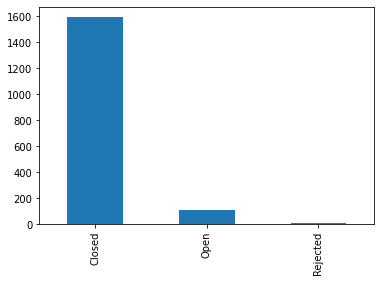

In [0]:
data['status'].value_counts().plot(kind = 'bar')

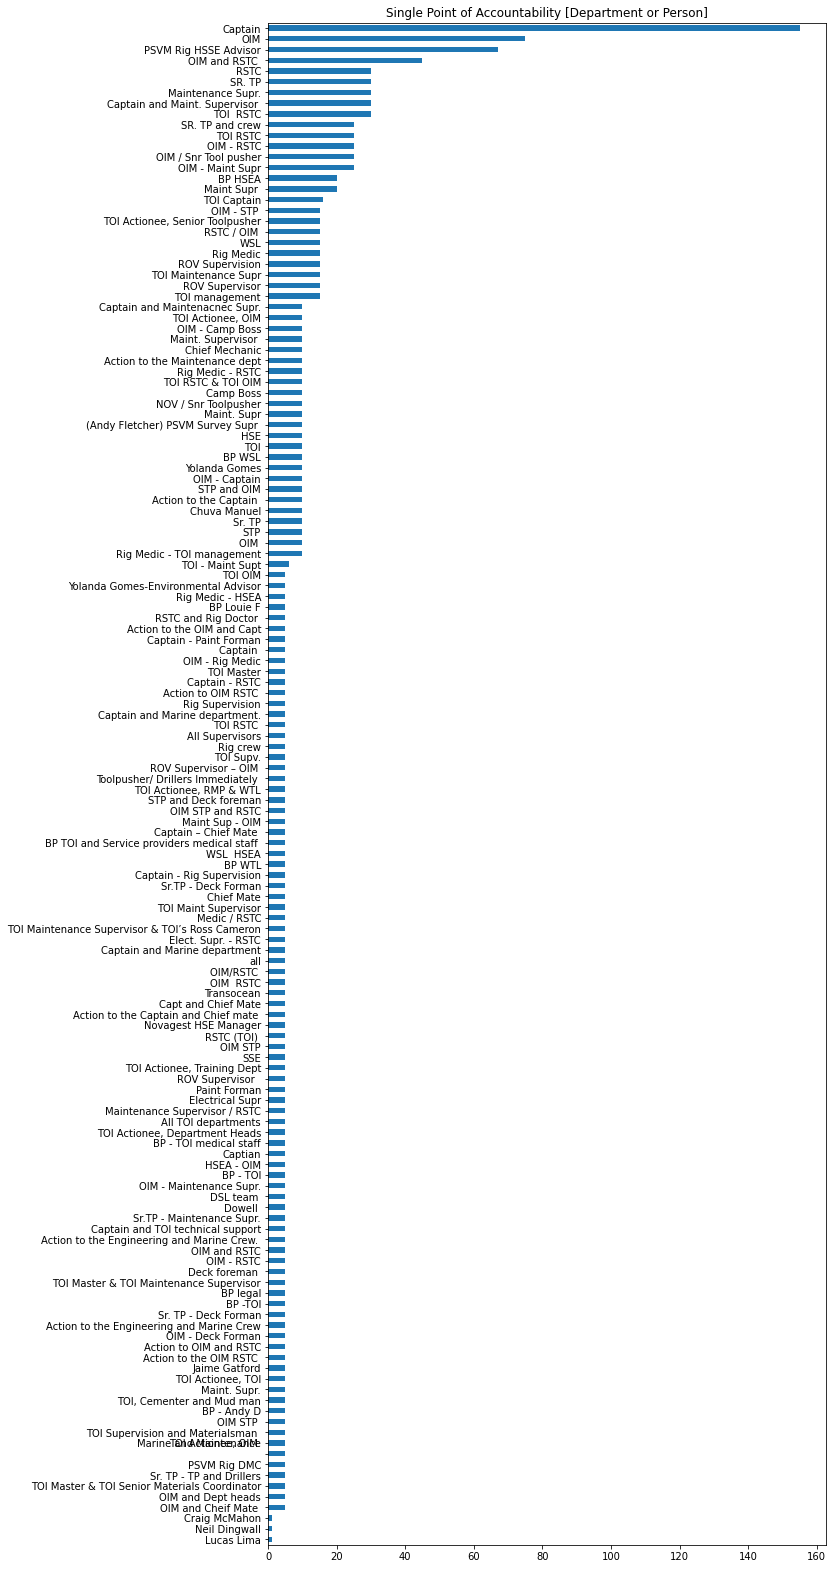

In [0]:
plt.figure(figsize=(10,28))
data['SPA'].value_counts().plot(kind = 'barh')
plt.gca().invert_yaxis()
plt.title('Single Point of Accountability [Department or Person]')
plt.show()

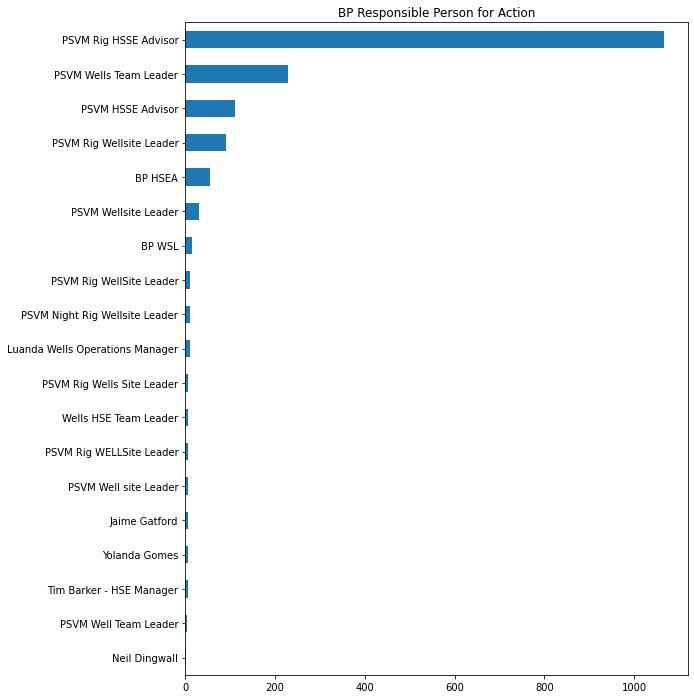

In [0]:
plt.figure(figsize=(9,12))
data['responsible_person'].value_counts().plot(kind = 'barh')
plt.gca().invert_yaxis()
plt.title('BP Responsible Person for Action')
plt.show()

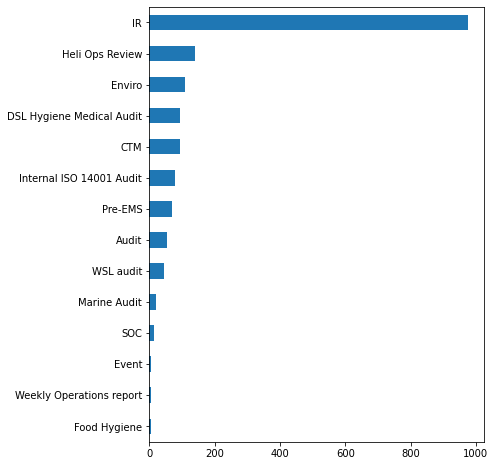

In [0]:
plt.figure(figsize = (6,8))
data['action_source'].value_counts().plot(kind = 'barh')
plt.gca().invert_yaxis()
plt.show()

## Content-Based Filtering Model

In [0]:
stopword_list = stopwords.words('english')

In [0]:
vectorizer = TfidfVectorizer(analyzer='word')

In [0]:
#build description tfidf matrix
tfidf_matrix = vectorizer.fit_transform(data['description'].values.astype('U'))

In [0]:
tfidf_feature_name = vectorizer.get_feature_names()

In [0]:
tfidf_matrix.shape

(1718, 1537)

In [0]:

# compying cosine similarity matrix using linear_kernal of sklearn
cosine_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)

In [0]:
data = data.reset_index(drop=True)

In [0]:
indices = pd.Series(data['description'].index)

In [0]:
#Function to get the most similar HSE Incidences
def recommend(index, method):
    id = indices[index]
    # Get the pairwise similarity scores of all Incidents compared that incident,
    # sorting them and getting top 10
    similarity_scores = list(enumerate(method[id]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:11]
    
    #Get the incident index
    hse_index = [i[0] for i in similarity_scores]
    
    #Return the top 5 most similar incidences using integar-location based indexing (iloc)
    return data['description'].iloc[hse_index]

In [0]:

#input the index of the incidence
recommend(297, cosine_similarity)

659           Pressure washer not being properly operated
689           Pressure washer not being properly operated
1034          Pressure washer not being properly operated
1379          Pressure washer not being properly operated
273     Radioactive PIP tags not properly managed or m...
274     Radioactive PIP tags not properly managed or m...
625     Radioactive PIP tags not properly managed or m...
626     Radioactive PIP tags not properly managed or m...
964     Radioactive PIP tags not properly managed or m...
965     Radioactive PIP tags not properly managed or m...
Name: description, dtype: object

In [0]:
data.iloc[297]

id                                                                    7
action_source                                                        IR
target_date                                                  10/10/2010
description                 Pressure washer not being properly operated
action                TOI rig supervision are to find the best solut...
SPA                                           Sr.TP - Maintenance Supr.
responsible_person                                    PSVM HSSE Advisor
how_action_closed     TSTP developed DSL-009 and training will be pr...
status                                                           Closed
Name: 297, dtype: object

In [0]:
data['all_content'] = data['description'] + data['action'] + data['target_date'] + data['responsible_person'] + data['SPA'] + data['status'] + data['how_action_closed']

In [0]:
tfidf_all_content = vectorizer.fit_transform(data['all_content'].values.astype('U'))

In [0]:
tfidf_all_content.shape

(1718, 3291)

In [0]:
# comping cosine similarity matrix using linear_kernal of sklearn
cosine_similarity_all_content = linear_kernel(tfidf_all_content, tfidf_all_content)

In [0]:
recommend(297, cosine_similarity_all_content)

659           Pressure washer not being properly operated
689           Pressure washer not being properly operated
1034          Pressure washer not being properly operated
1379          Pressure washer not being properly operated
130     Recommend both medics receive training to Inte...
481     Recommend both medics receive training to Inte...
759     Recommend both medics receive training to Inte...
1104    Recommend both medics receive training to Inte...
1449    Recommend both medics receive training to Inte...
57                                   Lifting Loads safely
Name: description, dtype: object